<a href="https://colab.research.google.com/github/Followb1ind1y/Distracted_Driver_Detection_Project/blob/main/State_Farm_Distracted_Driver_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **State Farm Distracted Driver Detection Project**

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

## **1. Obtaining and Organizing the Dataset**

### **1.1. Download Dataset from kaggle**

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [ ]:
!kaggle competitions download -c state-farm-distracted-driver-detection

100% 3.99G/4.00G [00:21<00:00, 143MB/s]
100% 4.00G/4.00G [00:21<00:00, 199MB/s]


In [ ]:
!unzip /content/state-farm-distracted-driver-detection.zip

### **1.2. Data Visualization**

In [ ]:
dataset = pd.read_csv('driver_imgs_list.csv')
dataset.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


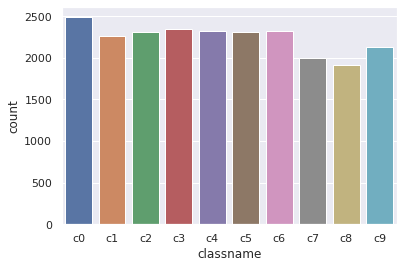

In [ ]:
import seaborn as sns

# Number of images by category
sns.set_theme(style="darkgrid")
sns.countplot(x = 'classname', data=dataset)

###**1.3. Organizing the Dataset**

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

data_dir = '/content/imgs/train'
splitfolders.ratio(data_dir, output="output", ratio=(0.8, 0.1, 0.1))

Copying files: 22424 files [00:05, 4228.47 files/s]


In [ ]:
train_dir = '/content/output/train'
val_dir = '/content/output/val'
test_dir = '/content/output/test'

# classes are folders in each directory with these names
CLASSES = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

## **2. Image Augmentation**

In [ ]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
    torchvision.transforms.AutoAugment(torchvision.transforms.AutoAugmentPolicy.IMAGENET),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))])

## **3. Reading the Dataset**

In [ ]:
BATCH_SIZE = 64

train_data = torchvision.datasets.ImageFolder(train_dir, transform=transform_train)
val_data = torchvision.datasets.ImageFolder(val_dir, transform=transform_train)
test_data = torchvision.datasets.ImageFolder(test_dir, transform=transform_train)

train_loader = torch.utils.data.DataLoader(train_data, BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_data, BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, BATCH_SIZE, shuffle=True, drop_last=True)

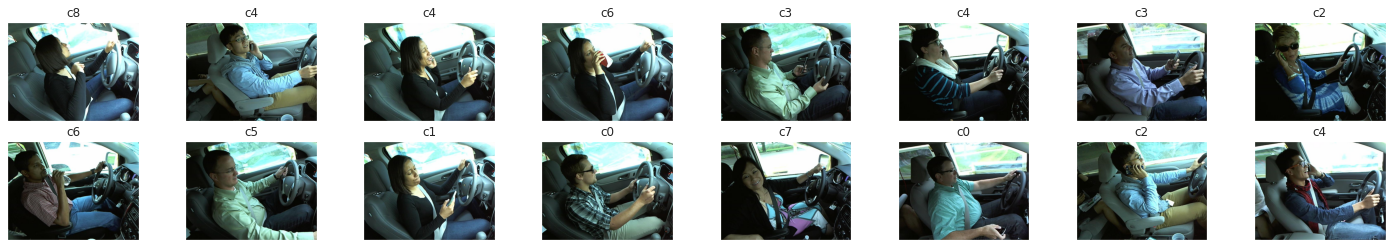

In [ ]:
display_data = torchvision.datasets.ImageFolder(train_dir, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
display_loader = torch.utils.data.DataLoader(display_data, BATCH_SIZE, shuffle=True, drop_last=True)

# Visualize some sample data from the original dataset

dataiter = iter(display_loader) # obtain one batch of training images
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    plt.imshow((255*np.transpose(images[idx], (1, 2, 0))).astype(np.uint8))
    ax.set_title(CLASSES[labels[idx]])

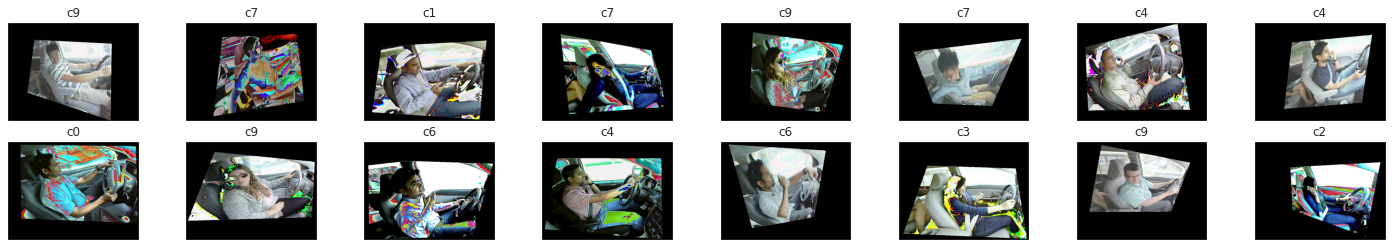

In [ ]:
# Visualize some sample data after Augmentation

dataiter = iter(train_loader) # obtain one batch of training images
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    plt.imshow((255*np.transpose(images[idx], (1, 2, 0))).astype(np.uint8))
    ax.set_title(CLASSES[labels[idx]])

## **4. Defining the Model**